In [ ]:
import pandas_datareader as pdr

In [ ]:
key = '8610ff98c24472d674688b2722b11f83566a296d'
df = pdr.get_data_tiingo('NVDA', api_key = key)

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [ ]:
df.to_csv('NVDA.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('NVDA.csv')

In [ ]:
df1 = df.reset_index()['close']

In [ ]:
df1.shape

(1259,)

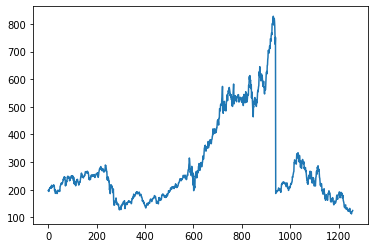

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
df1

array([[0.11786158],
       [0.12074001],
       [0.1137256 ],
       ...,
       [0.01151369],
       [0.01351181],
       [0.01731245]])

In [ ]:
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size, :], df1[training_size:len(df1),:1]


In [ ]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 6s 209ms/step - loss: 0.0330 - val_loss: 0.0189
Epoch 2/100
12/12 [==============================] - 1s 120ms/step - loss: 0.0042 - val_loss: 0.0293
Epoch 3/100
12/12 [==============================] - 1s 125ms/step - loss: 0.0015 - val_loss: 0.0242
Epoch 4/100
12/12 [==============================] - 2s 171ms/step - loss: 0.0012 - val_loss: 0.0205
Epoch 5/100
12/12 [==============================] - 3s 221ms/step - loss: 9.9146e-04 - val_loss: 0.0214
Epoch 6/100
12/12 [==============================] - 2s 125ms/step - loss: 8.7659e-04 - val_loss: 0.0185
Epoch 7/100
12/12 [==============================] - 1s 125ms/step - loss: 8.7883e-04 - val_loss: 0.0169
Epoch 8/100
12/12 [==============================] - 1s 124ms/step - loss: 8.4483e-04 - val_loss: 0.0176
Epoch 9/100
12/12 [==============================] - 1s 121ms/step - loss: 8.4336e-04 - val_loss: 0.0184
Epoch 10/100
12/12 [==============================] - 1s 119ms/step - l

In [ ]:
import tensorflow as tf

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 22ms/step


In [ ]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

293.4515792674892

In [ ]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

278.5631422665583

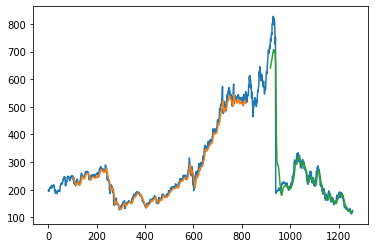

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
len(test_data)

441

In [ ]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 101)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.09910992 0.11688348 0.10469909 0.10562131 0.10757751 0.10369304
 0.09530929 0.08030237 0.06176031 0.06440119 0.07405648 0.06111755
 0.065016   0.07460142 0.071723   0.06983666 0.08242626 0.07883522
 0.06644124 0.06029315 0.05494152 0.04605475 0.0522168  0.05453631
 0.06470859 0.06442914 0.05484371 0.05386561 0.05501139 0.05791776
 0.06336719 0.06810401 0.08055389 0.09194182 0.09533724 0.08512303
 0.08100102 0.07414032 0.09170428 0.09441502 0.09691618 0.10080065
 0.10198835 0.10711641 0.11161569 0.10845781 0.0917462  0.08186734
 0.09599396 0.09382816 0.10454539 0.10905864 0.10692079 0.09931952
 0.10543966 0.09252868 0.08114075 0.08319477 0.08376766 0.09342295
 0.07032571 0.06391214 0.05925916 0.05403328 0.03786661 0.03381447
 0.0312714  0.03475065 0.03860718 0.04415443 0.04580323 0.02660444
 0.02656252 0.02378191 0.02754063 0.03011164 0.02723322 0.02842092
 0.01863988 0.01801109 0.01398689 0.01657188 0.02108514 0.01387511
 0.0127433  0.0179552  0.02710747 0.02769433 0.026

In [ ]:
##print(scaler.inverse_transform(lst_output))
dates = [0,1,2,3,4,5,6,7,8,9]
data = pd.DataFrame(scaler.inverse_transform(lst_output).round(2),dates,columns=['Close'])

In [ ]:
from google.colab import files

data.to_csv('Tan Sher Yew_Impl_1.csv', encoding = 'utf-8-sig') 
files.download('Tan Sher Yew_Impl_1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>